# Monte Carlo Simulations for Stock Portfolio by using Geometric Geometric Brownian Motion (GBM)

In [43]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
#import talib as ta
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd




###  Stochastic Differential Equation GBM 

dp/p = mu * dt + sigma * weights

weights follow normal distribution N ~ (0,1)



In [45]:
def MC_simulations(df,n,mu,sigma):
  
  T = df.shape[0] # step size : days
  # initalize - for every MC simulation
  price = pd.DataFrame(0,index=df.index,columns=list(range(0,n)))
  # for the 1st value - initalize with actual value
  price.iloc[0]=df['Close'].iloc[0] 
  
  # step size : 1 day in yearly scale
  dt = 1/(T-1)

  # MC - differential equation
  for i in range(1,T):
    weights = np.sqrt(dt)*np.random.randn(n)
    dp_p = mu * dt + sigma * weights  
    price.iloc[i] = price.iloc[i-1] + price.iloc[i-1]*dp_p
    if i%50==0:
      print(f'running for {i}-th day out of {T} days')

  return price

In [46]:

def plot_result(df,n,sample_size,price):
  # plot result
  fig = px.line(df['Close'])
  fig.update_traces(line_color='red', line_width=4)
  # name of the MC lines
  mc = ['MC_'+str(i) for i in range(1,21)]
  # randomly select 20 MC simulations
  random_samples = np.random.choice(np.array(range(1,n+1)),size=sample_size)
  for i,_ in enumerate(random_samples):
    fig.add_scatter(x=price.index, y=price[i],name=mc[i], mode='lines',line=dict(color='blue',width=2))

  fig.show()

### Lets check Evaluated values against Theoretical Values

Expected value E[p] = p_0 * exp(mu * t) 


Median = p_0 * exp(mu * t - (sig ^ 2) * t/2

In [47]:
def compare_result(df,price,mu,sigma):

  T = df.shape[0] # size of data
  # compare mean
  price_eval_mean = price.mean(axis=1)
  price_theo_mean = pd.DataFrame(df['Close'].iloc[0]*np.exp(mu*np.arange(0,T)/T*2),
                                index=price_eval_mean.index,columns=['Theoretical_Mean'])
  fig = plt.figure(figsize=(15,10))
  plt.plot(price_eval_mean,label='Theoretical mean')
  plt.plot(price_theo_mean,label='Evaluated mean')
  plt.xlabel('Date')
  plt.ylabel('Expected Value')
  plt.title('MC simulation mean comparison')
  plt.legend()
  plt.show()

  # compare median
  price_eval_median = price.median(axis=1)
  price_theo_median = pd.DataFrame(df['Close'].iloc[0]*np.exp(mu - 0.5*sigma*sigma)*np.arange(0,T)/T*2,
                               index=price_eval_median.index,columns=['Theoretical_Median'])
  fig = plt.figure(figsize=(15,10))
  plt.plot(price_eval_median,label='Theoretical median')
  plt.plot(price_theo_median,label='Evaluated median')
  plt.xlabel('Date')
  plt.ylabel('Expected Value')
  plt.title('MC simulation median comparison')
  plt.legend()
  plt.show()

In [48]:
df = yf.download('RELIANCE.NS',start='2022-01-01',end='2022-12-31',interval = "1D")


fig = go.Figure(data=[go.Candlestick(x=df.index, open=df['Open'], high=df['High'],low=df['Low'], close=df['Close'])])

fig.update_layout(
    title='Candlestick Chart',
    yaxis_title='RELIANCE.NS Stock',
)


fig.show()

[*********************100%***********************]  1 of 1 completed


In [49]:
n = 2000 # n = no. of simulations
sample_size = 20 # no of simulations we want to visualize
sigma = 0.25 # annual volatility : 25%
mu = 0.08 # drift : long term growth assumption 

In [50]:

price = MC_simulations(df,n,mu,sigma) 
plot_result(df,n,sample_size,price)


running for 50-th day out of 248 days
running for 100-th day out of 248 days
running for 150-th day out of 248 days
running for 200-th day out of 248 days


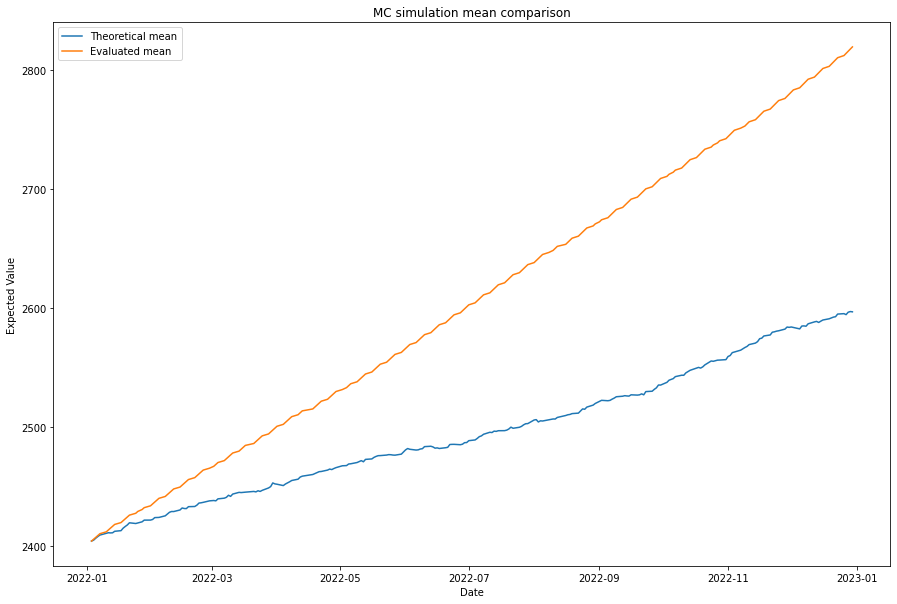

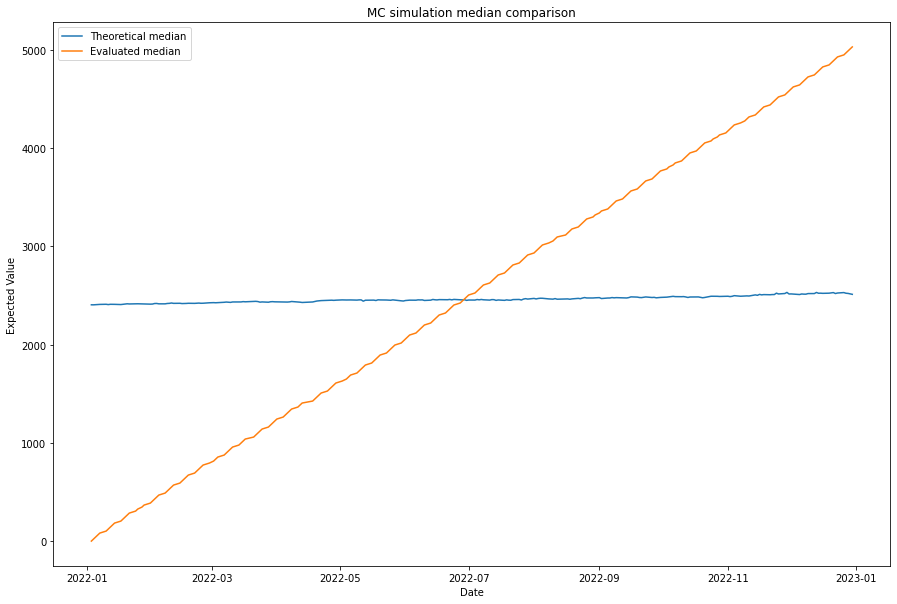

In [51]:
compare_result(df,price,mu,sigma)

In [52]:
df = yf.download('HDFCBANK.NS',start='2022-01-01',end='2022-12-31',interval = "1D")

fig = go.Figure(data=[go.Candlestick(x=df.index, open=df['Open'], high=df['High'],low=df['Low'], close=df['Close'])])

fig.update_layout(
    title='Candlestick Chart',
    yaxis_title='RELIANCE.NS Stock',
)


fig.show()


[*********************100%***********************]  1 of 1 completed


In [53]:
price = MC_simulations(df,n,mu,sigma) 
plot_result(df,n,sample_size,price)

running for 50-th day out of 248 days
running for 100-th day out of 248 days
running for 150-th day out of 248 days
running for 200-th day out of 248 days


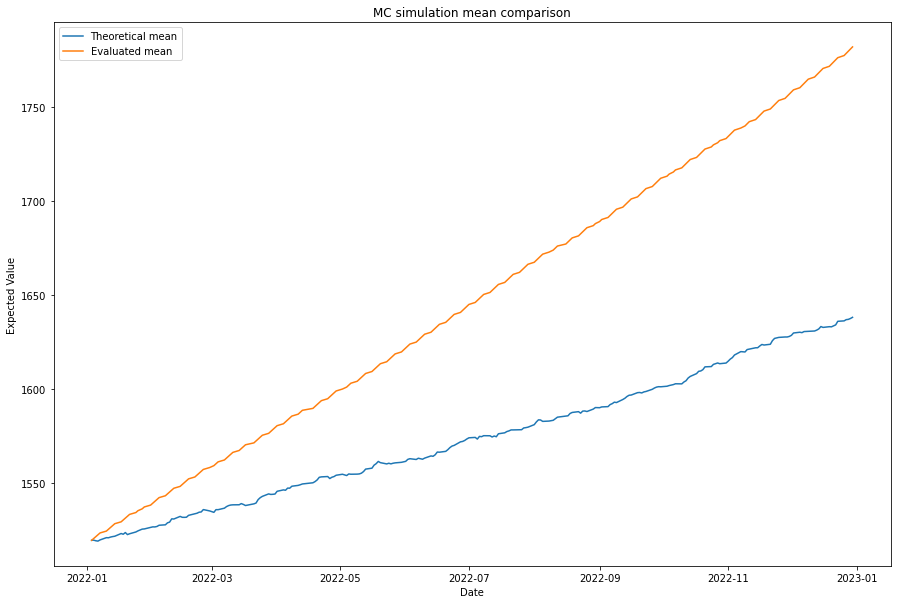

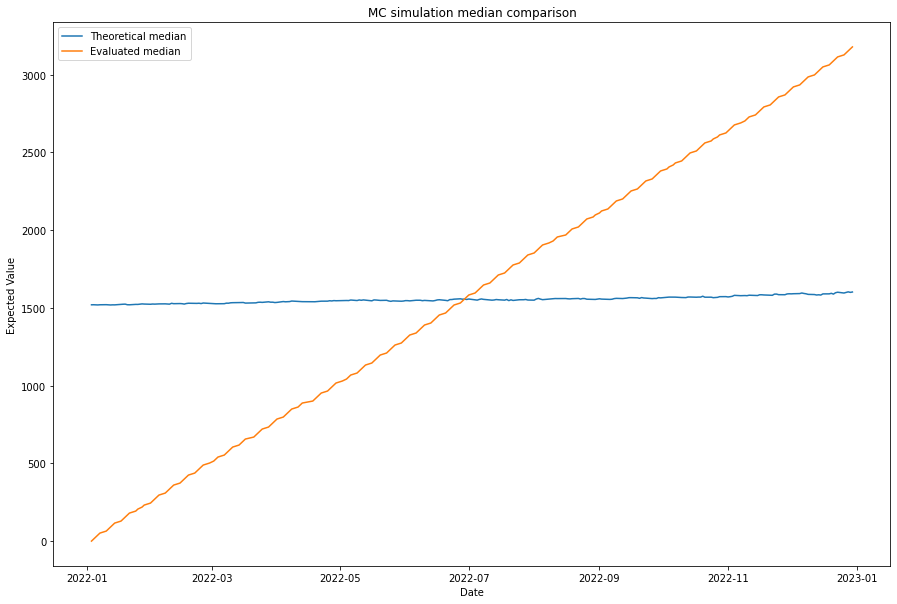

In [54]:
compare_result(df,price,mu,sigma)

In [55]:
#

In [56]:
tickers = ['HDFCBANK.NS','RELIANCE.NS']
df = yf.download(tickers,start='2022-01-01',end='2022-12-31',interval = "1D")

fig = px.line(df['Close'])
fig.update_layout(
    title='Close Price Chart',
    yaxis_title='Close Price',
)
fig.show()

[*********************100%***********************]  2 of 2 completed


# Simulating Stock Portfolio containing 2 Stocks

Assuming daily returns (R) are distributed by a Multivariate Normal Distribution

Cholesky Decomposition is used to determine Lower Triangular Matrix 

L ~ LL' = sigma 

R = mu + L*Z

Z ~ N (0,I)

In [57]:
def run_MC(df,n,T,inital):
  mean_ = df['Close'].pct_change().mean()
  cov_= df['Close'].pct_change().cov()

  weights = np.random.random(len(mean_))
  weights /= np.sum(weights) # scale down

  # initalization - mean matrix(2,T) for 2 stocks
  mu = np.full(shape=(T, len(weights)), fill_value=mean_).T
  # initalization -  MC simulation (T,20000)
  portfolio = np.full(shape=(T, n), fill_value=0.0)

  for i in range(0,n):
      Z = np.random.normal(size=(T, len(weights)))
      # cholesky decomposition to lower triangular matrix
      L = np.linalg.cholesky(cov_) 
      # correlated daily returns for individual stocks
      daily_return = mu + np.inner(L, Z) 
      portfolio[:,i] = np.cumprod(np.inner(weights, daily_return.T)+1)*initial
      if i % 1000 == 0:
        print(f'Running {i}-th MC simulation out of {n} simulations')
  
  return portfolio

In [58]:
n = 20000 # number of simulations
T = df.shape[0] #timeframe in days
initial = 10000

In [59]:
portfolio=run_MC(df,n,T,initial)
portfolio = pd.DataFrame(portfolio,columns=['P&L_'+str(i)for i in range(n)])
portfolio.index = df.index


Running 0-th MC simulation out of 20000 simulations
Running 1000-th MC simulation out of 20000 simulations
Running 2000-th MC simulation out of 20000 simulations
Running 3000-th MC simulation out of 20000 simulations
Running 4000-th MC simulation out of 20000 simulations
Running 5000-th MC simulation out of 20000 simulations
Running 6000-th MC simulation out of 20000 simulations
Running 7000-th MC simulation out of 20000 simulations
Running 8000-th MC simulation out of 20000 simulations
Running 9000-th MC simulation out of 20000 simulations
Running 10000-th MC simulation out of 20000 simulations
Running 11000-th MC simulation out of 20000 simulations
Running 12000-th MC simulation out of 20000 simulations
Running 13000-th MC simulation out of 20000 simulations
Running 14000-th MC simulation out of 20000 simulations
Running 15000-th MC simulation out of 20000 simulations
Running 16000-th MC simulation out of 20000 simulations
Running 17000-th MC simulation out of 20000 simulations
Runni

In [60]:
print('Mean return from MC simulations ',portfolio.mean())

Mean return from MC simulations  P&L_0         9288.594206
P&L_1        10730.695468
P&L_2        14684.462434
P&L_3        11158.191042
P&L_4        12774.610110
                 ...     
P&L_19995    11224.024327
P&L_19996    10254.050794
P&L_19997     8879.253016
P&L_19998    10539.149547
P&L_19999     9882.459172
Length: 20000, dtype: float64


In [61]:
sample_size = 20
# plot result
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close']['HDFCBANK.NS'],mode='lines',
                         name='HDFCBANK.NS',line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=df.index, y=df['Close']['RELIANCE.NS'],mode='lines',
                         name='RELIANCE.NS',line=dict(color='chartreuse', width=4)))
fig.add_trace(go.Scatter(x=df.index, y=portfolio.mean(axis=0),mode='lines',
                         name='MC avg per day',line=dict(color='tomato', width=2)))
initial_capital = [initial for i in range(len(df.index))]
fig.add_trace(go.Scatter(x=df.index, y=initial_capital,mode='lines',
                         name='initial capital',line=dict(color='black', width=4)))

# randomly select 20 MC simulations
random_samples = np.random.choice(np.array(range(1,n+1)),size=sample_size)
# name of the MC lines
mc = ['MC_'+str(i) for i in range(1,21)]
for i,_ in enumerate(random_samples):
  fig.add_scatter(x=portfolio.index, y=portfolio.iloc[i], mode='lines',name=mc[i],line=dict(color='steelblue',width=2))


fig.show()

In [62]:
#